In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import progressbar
import warnings
warnings.filterwarnings('ignore')

from xgboost import XGBRegressor
from sklearn.ensemble import (RandomForestRegressor, AdaBoostRegressor, 
                              GradientBoostingRegressor, ExtraTreesRegressor)
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn.metrics import accuracy_score

E:\program\Anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



## load data

In [2]:
train_feature_df = pd.read_csv('train_feature.csv', low_memory=False)
train_label_df = pd.read_csv('train_label.csv', low_memory=False)
test_feature_df = pd.read_csv('test_feature.csv', low_memory=False)
print(train_feature_df.shape, train_label_df.shape, test_feature_df.shape)

(17008, 8) (2126, 2) (7320, 8)


## 1 remake the data for each day
should be 7*8+2=58 cols

In [3]:
train_feature_df_list = []
for i in [2,5,8,11,14,17,20,23]:
    temp_df = train_feature_df[train_feature_df['时刻'] == i].add_suffix('_'+str(i))
    temp_df.rename(columns={'日期_'+str(i):'日期'}, inplace=True)
    train_feature_df_list.append(temp_df )

In [4]:
for i in range(8):
    train_label_df = train_label_df.merge(train_feature_df_list[i], left_on = '日期', right_on='日期', how='left', suffixes=('',''))
train_label_df.head()

,日期,电场实际太阳辐射指数,时刻_2,辐照度_2,风速_2,风向_2,温度_2,湿度_2,气压_2,时刻_5,...,温度_20,湿度_20,气压_20,时刻_23,辐照度_23,风速_23,风向_23,温度_23,湿度_23,气压_23
0,1,0.108799,2,0,2.1,343,-7.2,51,69800,5,...,-3.5,40,69700,23,0,0.8,14,-4.8,42,69700
1,2,0.130559,2,0,1.1,45,-5.2,46,69800,5,...,-3.8,45,69400,23,0,2.5,297,-5.4,48,69500
2,3,0.114239,2,0,2.9,278,-7.4,58,69500,5,...,-3.8,30,69500,23,0,0.8,140,-3.8,29,69500
3,4,0.081599,2,0,0.3,90,-6.1,38,69500,5,...,-3.0,21,69100,23,0,0.8,270,-6.3,26,69200
4,5,0.212158,2,0,1.4,231,-9.9,33,69100,5,...,-6.1,26,69200,23,0,1.1,63,-7.5,28,69300


## 2. normalize data

In [5]:
fcol = [c for c in train_label_df.columns if c not in ['日期', '时刻_2', '时刻_5', '时刻_8', '时刻_11', '时刻_14',
                                             '时刻_17', '时刻_20', '时刻_23','辐照度_2', '辐照度_5','辐照度_23', '电场实际太阳辐射指数']]

X = train_label_df[fcol].values
y = train_label_df['电场实际太阳辐射指数']

In [6]:
# Scaling of X values
mins = np.min(X, axis=0)
maxs = np.max(X, axis=0)
rng = maxs - mins
X = 1 - ((maxs - X) / rng)

# Test Dataset

In [7]:
test_feature_df = test_feature_df.iloc[0:7296]
print('dates in test dataset is : ', test_feature_df.shape[0]/8)

dates in test dataset is :  912.0


In [8]:
# initalize the test label
index = np.arange(912)
columns = ['日期']
data = np.array([np.arange(1, 913)]).T
test_label_df = pd.DataFrame(data, index=index, columns=columns)

In [9]:
test_feature_df_list = []
for i in [2,5,8,11,14,17,20,23]:
    temp_df = test_feature_df[test_feature_df['时刻'] == i].add_suffix('_'+str(i))
    temp_df.rename(columns={'日期_'+str(i):'日期'}, inplace=True)
    test_feature_df_list.append(temp_df )
    
for i in range(8):
    test_label_df = test_label_df.merge(test_feature_df_list[i], left_on = '日期', right_on='日期', how='left', suffixes=('',''))

In [10]:
x_test = test_label_df[fcol].values
x_test = 1 - ((maxs - x_test) / rng)
x_test.shape

(912, 45)

## Parameter choose

In [20]:
def parameter_choose(model, param_grid, if_plot = True):
    kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=7)
    grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_absolute_error", n_jobs=-1, cv=kfold, verbose=1)
    grid_result = grid_search.fit(X, y)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    # plot results
    if if_plot:
        scores = np.array(means).reshape(len(param_grid['max_depth']), len(param_grid['n_estimators']))
        for i, value in enumerate(param_grid['max_depth']):
            pyplot.plot(n_estimators, scores[i], label='depth: ' + str(value))
        pyplot.legend()
        pyplot.xlabel('n_estimators')
        pyplot.ylabel('Log Loss')

## RandomForest

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  3.1min finished


Best: -0.168925 using {'max_depth': 4, 'n_estimators': 200}
-0.174437 (0.009279) with: {'max_depth': 2, 'n_estimators': 50}
-0.174962 (0.009422) with: {'max_depth': 2, 'n_estimators': 100}
-0.174911 (0.009234) with: {'max_depth': 2, 'n_estimators': 150}
-0.174897 (0.009503) with: {'max_depth': 2, 'n_estimators': 200}
-0.174904 (0.009267) with: {'max_depth': 2, 'n_estimators': 250}
-0.174844 (0.009300) with: {'max_depth': 2, 'n_estimators': 300}
-0.168939 (0.008853) with: {'max_depth': 4, 'n_estimators': 50}
-0.169087 (0.008912) with: {'max_depth': 4, 'n_estimators': 100}
-0.169320 (0.008863) with: {'max_depth': 4, 'n_estimators': 150}
-0.168925 (0.008592) with: {'max_depth': 4, 'n_estimators': 200}
-0.168983 (0.008694) with: {'max_depth': 4, 'n_estimators': 250}
-0.169163 (0.008767) with: {'max_depth': 4, 'n_estimators': 300}
-0.170281 (0.008237) with: {'max_depth': 6, 'n_estimators': 50}
-0.169768 (0.008250) with: {'max_depth': 6, 'n_estimators': 100}
-0.169824 (0.007654) with: {'max_

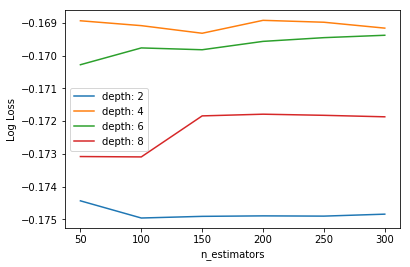

In [21]:
model = RandomForestRegressor()
n_estimators = [50, 100, 150, 200, 250, 300]
max_depth = [2, 4, 6, 8]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
parameter_choose(model, param_grid)

In [37]:
model = RandomForestRegressor()
n_estimators = [150, 180, 200]
max_depth = [4,5,6]
min_samples_leaf = [1,2,3]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, min_samples_leaf=min_samples_leaf)
parameter_choose(model, param_grid, False)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  4.6min finished


Best: -0.168772 using {'n_estimators': 200, 'max_depth': 5, 'min_samples_leaf': 3}
-0.169123 (0.008607) with: {'n_estimators': 150, 'max_depth': 4, 'min_samples_leaf': 1}
-0.169130 (0.008423) with: {'n_estimators': 180, 'max_depth': 4, 'min_samples_leaf': 1}
-0.168945 (0.008770) with: {'n_estimators': 200, 'max_depth': 4, 'min_samples_leaf': 1}
-0.169079 (0.008556) with: {'n_estimators': 150, 'max_depth': 4, 'min_samples_leaf': 2}
-0.169174 (0.008970) with: {'n_estimators': 180, 'max_depth': 4, 'min_samples_leaf': 2}
-0.169052 (0.008715) with: {'n_estimators': 200, 'max_depth': 4, 'min_samples_leaf': 2}
-0.169218 (0.008779) with: {'n_estimators': 150, 'max_depth': 4, 'min_samples_leaf': 3}
-0.168963 (0.008872) with: {'n_estimators': 180, 'max_depth': 4, 'min_samples_leaf': 3}
-0.168909 (0.008807) with: {'n_estimators': 200, 'max_depth': 4, 'min_samples_leaf': 3}
-0.168941 (0.007905) with: {'n_estimators': 150, 'max_depth': 5, 'min_samples_leaf': 1}
-0.169042 (0.008265) with: {'n_estima

Best: -0.168845 using {'n_estimators': 150, 'max_depth': 4, 'min_samples_leaf': 1}

Best: -0.168509 using {'n_estimators': 180, 'max_depth': 5, 'min_samples_leaf': 2}

Best: -0.168772 using {'n_estimators': 200, 'max_depth': 5, 'min_samples_leaf': 3}

## ExtraTrees

In [38]:
model = ExtraTreesRegressor()
n_estimators = [100, 80, 60]
max_depth = [5, 6, 7]
min_samples_leaf = [3,4, 5]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, min_samples_leaf=min_samples_leaf)
parameter_choose(model, param_grid, False)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   41.4s finished


Best: -0.168528 using {'n_estimators': 100, 'max_depth': 6, 'min_samples_leaf': 5}
-0.169724 (0.008107) with: {'n_estimators': 100, 'max_depth': 5, 'min_samples_leaf': 3}
-0.169396 (0.008182) with: {'n_estimators': 80, 'max_depth': 5, 'min_samples_leaf': 3}
-0.169425 (0.008050) with: {'n_estimators': 60, 'max_depth': 5, 'min_samples_leaf': 3}
-0.169292 (0.008092) with: {'n_estimators': 100, 'max_depth': 5, 'min_samples_leaf': 4}
-0.169348 (0.008050) with: {'n_estimators': 80, 'max_depth': 5, 'min_samples_leaf': 4}
-0.169385 (0.008328) with: {'n_estimators': 60, 'max_depth': 5, 'min_samples_leaf': 4}
-0.169356 (0.008055) with: {'n_estimators': 100, 'max_depth': 5, 'min_samples_leaf': 5}
-0.169572 (0.008225) with: {'n_estimators': 80, 'max_depth': 5, 'min_samples_leaf': 5}
-0.169613 (0.007905) with: {'n_estimators': 60, 'max_depth': 5, 'min_samples_leaf': 5}
-0.169069 (0.008291) with: {'n_estimators': 100, 'max_depth': 6, 'min_samples_leaf': 3}
-0.168798 (0.007962) with: {'n_estimators':

Best: -0.169201 using {'n_estimators': 150, 'max_depth': 5, 'min_samples_leaf': 2}

Best: -0.168628 using {'n_estimators': 80, 'max_depth': 6, 'min_samples_leaf': 4}

Best: -0.168528 using {'n_estimators': 100, 'max_depth': 6, 'min_samples_leaf': 5}

## AdaBoost

In [30]:
model = AdaBoostRegressor()
n_estimators = [30,40,50, 60,70]
learning_rate = [0.1, 0.05, 0.08, 0.15, 0.18]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)
parameter_choose(model, param_grid, False)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   49.0s finished


Best: -0.171021 using {'n_estimators': 40, 'learning_rate': 0.05}
-0.171886 (0.008898) with: {'n_estimators': 30, 'learning_rate': 0.1}
-0.171261 (0.009139) with: {'n_estimators': 40, 'learning_rate': 0.1}
-0.171894 (0.009065) with: {'n_estimators': 50, 'learning_rate': 0.1}
-0.172544 (0.009226) with: {'n_estimators': 60, 'learning_rate': 0.1}
-0.172818 (0.008926) with: {'n_estimators': 70, 'learning_rate': 0.1}
-0.171950 (0.009284) with: {'n_estimators': 30, 'learning_rate': 0.05}
-0.171021 (0.009529) with: {'n_estimators': 40, 'learning_rate': 0.05}
-0.171079 (0.009886) with: {'n_estimators': 50, 'learning_rate': 0.05}
-0.171103 (0.009207) with: {'n_estimators': 60, 'learning_rate': 0.05}
-0.171430 (0.009407) with: {'n_estimators': 70, 'learning_rate': 0.05}
-0.171470 (0.009113) with: {'n_estimators': 30, 'learning_rate': 0.08}
-0.171402 (0.009489) with: {'n_estimators': 40, 'learning_rate': 0.08}
-0.171686 (0.009026) with: {'n_estimators': 50, 'learning_rate': 0.08}
-0.171767 (0.009

Best: -0.171021 using {'n_estimators': 40, 'learning_rate': 0.05}

## GradientBoosting

In [31]:
model = GradientBoostingRegressor()
n_estimators = [50,80, 100, 120]
max_depth = [1, 2, 3]
min_samples_leaf = [1,2,3]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, min_samples_leaf=min_samples_leaf)
parameter_choose(model, param_grid, False)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   22.6s finished


Best: -0.167289 using {'n_estimators': 100, 'max_depth': 2, 'min_samples_leaf': 2}
-0.173441 (0.008568) with: {'n_estimators': 50, 'max_depth': 1, 'min_samples_leaf': 1}
-0.171711 (0.008287) with: {'n_estimators': 80, 'max_depth': 1, 'min_samples_leaf': 1}
-0.171270 (0.008219) with: {'n_estimators': 100, 'max_depth': 1, 'min_samples_leaf': 1}
-0.170964 (0.008168) with: {'n_estimators': 120, 'max_depth': 1, 'min_samples_leaf': 1}
-0.173441 (0.008568) with: {'n_estimators': 50, 'max_depth': 1, 'min_samples_leaf': 2}
-0.171751 (0.008288) with: {'n_estimators': 80, 'max_depth': 1, 'min_samples_leaf': 2}
-0.171356 (0.008220) with: {'n_estimators': 100, 'max_depth': 1, 'min_samples_leaf': 2}
-0.171044 (0.008163) with: {'n_estimators': 120, 'max_depth': 1, 'min_samples_leaf': 2}
-0.173441 (0.008568) with: {'n_estimators': 50, 'max_depth': 1, 'min_samples_leaf': 3}
-0.171721 (0.008294) with: {'n_estimators': 80, 'max_depth': 1, 'min_samples_leaf': 3}
-0.171338 (0.008203) with: {'n_estimators':

Best: -0.167289 using {'n_estimators': 100, 'max_depth': 2, 'min_samples_leaf': 2}

# Ensemble learning

In [41]:
x_train = X
y_train = y
print('shape of the x train is :', x_train.shape)
print('shape of the y train is :', y_train.shape)

shape of the x train is : (2126, 45)
shape of the y train is : (2126,)


In [42]:
# Some useful parameters which will come in handy later on
ntrain = x_train.shape[0]
ntest = x_test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction

kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
        
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    
# Class to extend XGboost classifer

def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    oof_test = oof_test.reshape(-1, 1)
    return oof_train.reshape(-1, 1) , oof_test

## First level

In [43]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {'n_jobs': -1,'n_estimators': 180,'warm_start': True, 'max_depth': 5,'min_samples_leaf': 2, 
             'max_features' : 'sqrt','verbose': 0}

# Extra Trees Parameters
et_params = {'n_jobs': -1,'n_estimators':100,'max_depth': 6, 'min_samples_leaf': 4, 'verbose': 0}

# AdaBoost parameters
ada_params = {'n_estimators': 40,'learning_rate' : 0.05}

# Gradient Boosting parameters
gb_params = {'n_estimators': 100,'max_depth': 2,'min_samples_leaf': 2,'verbose': 0}

# Support Vector Classifier parameters 
svc_params = { 'kernel' : 'linear', 'C' : 0.025}

xgb_params = {'n_jobs': -1,'n_estimators':100,'max_depth': 2 }

In [44]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestRegressor, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesRegressor, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostRegressor, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingRegressor, seed=SEED, params=gb_params)
xgb = SklearnHelper(clf=XGBRegressor, seed=SEED, params=xgb_params)
#svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [45]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
print('Done Extra Trees')
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
print('Done Random Forest')
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
print('Done AdaBoost')
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
print('Done Gradient Boost')
xgb_oof_train, xgb_oof_test = get_oof(xgb,x_train, y_train, x_test) # Support Vector Classifier
print('Done XGB')
print("Training is complete")

Done Extra Trees
Done Random Forest
Done AdaBoost
Done Gradient Boost
Done XGB
Training is complete


In [46]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)
xgb_feature = xgb.feature_importances(x_train,y_train)

[0.00673561 0.00969992 0.04466623 0.0206366  0.00978916 0.00546641
 0.00882518 0.04825099 0.03181454 0.01086491 0.06944354 0.0063823
 0.00680104 0.07854601 0.02646668 0.00654161 0.02920315 0.00890798
 0.00722658 0.03910594 0.05882344 0.00825194 0.02845049 0.00722396
 0.00683382 0.04216189 0.02685853 0.00638293 0.01233836 0.01222093
 0.00716493 0.02842295 0.03633153 0.0061946  0.04413062 0.01293875
 0.01078644 0.02871671 0.02621021 0.00441169 0.01168465 0.00797312
 0.03163584 0.05338638 0.00509091]
[0.00443444 0.00772808 0.03519363 0.01884948 0.0074228  0.00559931
 0.00746555 0.0409493  0.02187347 0.00798422 0.11995719 0.00397355
 0.00474861 0.11706779 0.0167555  0.00765487 0.03549354 0.00593202
 0.00446749 0.0488612  0.02945572 0.0080899  0.03801566 0.00591313
 0.00519673 0.04037818 0.01916732 0.00368645 0.00674699 0.00893442
 0.00334814 0.01459579 0.02463967 0.00365485 0.07348498 0.01508396
 0.00417638 0.0607468  0.02602984 0.00347557 0.00568307 0.00482488
 0.02962145 0.03872516 0.003

## Second level

In [47]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, xgb_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, xgb_oof_test), axis=1)

In [62]:
print(x_train.shape, x_test.shape)

(2126, 5) (912, 5)


In [61]:
model = XGBRegressor()
eta = np.array([0.07,0.09, 0.11 ,0.13])
n_estimators = [80, 100, 120, 140]
max_depth = [4, 5, 6]
min_child_weight= [1, 2]
gamma = [0.8, 0.7, 0.6, 0.5, 0.9]
colsample_bytree = [0.8, 0.7, 0.9]
param_grid = dict(learning_rate = eta, max_depth = max_depth, n_estimators = n_estimators, 
                  min_child_weight = min_child_weight, gamma = gamma, colsample_bytree = colsample_bytree)
kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_absolute_error", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(x_train, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 10 folds for each of 1440 candidates, totalling 14400 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 329 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 829 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 1529 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-1)]: Done 2429 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3529 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 4829 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 6329 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 8029 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 9929 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 12029 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 14329 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 14393 out of 14400 | elapsed:  8.8min remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 14400 out of 14400 | elapsed:  8.8min finished


Best: -0.149461 using {'max_depth': 6, 'n_estimators': 140, 'gamma': 0.5, 'learning_rate': 0.13, 'min_child_weight': 2, 'colsample_bytree': 0.8}


Best: -0.152843 using {'gamma': 0.8, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.05}

Best: -0.149742 using {'gamma': 0.5, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.07}

Best: -0.151231 using {'max_depth': 5, 'n_estimators': 100, 'gamma': 0.6, 'learning_rate': 0.07, 'min_child_weight': 1, 'colsample_bytree': 0.8}

Best: -0.149461 using {'max_depth': 6, 'n_estimators': 140, 'gamma': 0.5, 'learning_rate': 0.13, 'min_child_weight': 2, 'colsample_bytree': 0.8}

In [63]:
xgb_up = XGBRegressor(
 learning_rate = 0.13,
 n_estimators= 140,
 max_depth= 6,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.5,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)

In [64]:
predictions = xgb_up.predict(x_test)

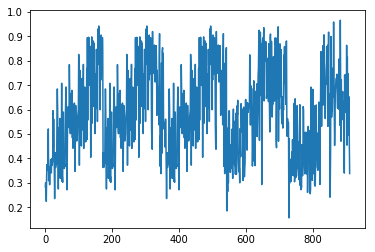

In [65]:
plt.plot(predictions)

### make submission

In [67]:
data = np.array([np.arange(1, 913)]).T
submission_df = pd.DataFrame(data, index=index, columns=columns)
submission_df['prediction'] = predictions
submission_df.rename(columns={'日期':'time'}, inplace=True)
submission_df.to_csv('submission1.csv', index=False)

In [ ]:
#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()    
    ]



#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = data1[Target]

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, data1[data1_x_bin], data1[Target], cv  = cv_split)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #save MLA predictions - see section 6 for usage
    alg.fit(data1[data1_x_bin], data1[Target])
    MLA_predict[MLA_name] = alg.predict(data1[data1_x_bin])
    
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict

In [ ]:
#barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')